In [404]:
import numpy as np
import re
import csv
import random

random.seed(42)

def tokenize(text):
    text = text.lower()
    words = re.findall(r"\b[a-zA-Z]+\b", text)
    return words
def load_data(file_name, max_labels=100):
    data = []
    labels_counter = {}
    with open(file_name, 'r', encoding="utf-8") as file:
        first = True
        for row in csv.reader(file):
            if not first:
                label = int(row[0])-1
                if label in [0,1,2]:
                    data.append((set(tokenize(row[1]+' '+row[2])), label))
            else:
                first = not first
    random.shuffle(data)
    short_data = []
    for row in data:
        label = row[1]
        if label not in labels_counter.keys():
            labels_counter[label] = 0
        if labels_counter[label] < max_labels:
            labels_counter[label]+=1
            short_data.append(row)
    return short_data

row_data_train = load_data(r".\train.csv")
row_data_test = load_data(r".\test.csv", 80)

print(row_data_train)
print(row_data_test)

[({'ex', 'his', 'naghma', 'who', 'afghan', 'a', 'early', 'started', 'dominated', 'prominent', 'he', 'scene', 'mangal', 'during', 'popular', 'dari', 'laghman', 'musical', 'music', 'pashto', 'wife', 'afghanistan', 'persian', 'were', 'pakistan', 'in', 'born', 'and', 'the', 'duo', 'is', 'singer', 'sings'}, 1), ({'ermocrate', 'mainly', 'still', 'with', 'painter', 'of', 'italian', 'lifes', 'bucchi', 'was', 'an', 'flowers'}, 1), ({'that', 'country', 'goes', 'charted', 's', 'charts', 'a', 'year', 'addition', 'number', 'houser', 'debut', 'anything', 'wrote', 'august', 'co', 'brice', 'gary', 'signed', 'also', 'released', 'to', 'william', 'music', 'chris', 'cagle', 'nothing', 'on', 'single', 'anywhere', 'here', 'which', 'records', 'was', 'but', 'in', 'billboard', 'later', 'hot', 'columbia', 'one', 'randy', 'born', 'and', 'the', 'by', 'is', 'singer', 'radio', 'american', 'long', 'allan', 'songs', 'an'}, 1), ({'his', 'include', 'who', 'according', 'printed', 'a', 'd', 'pseudonym', 'barford', 'he', 

In [405]:

all_words = []
for tokens, _ in row_data_train:
    all_words += tokens
all_words = sorted(set(all_words))
len(all_words)

3576

In [406]:
def one_hot(data, all_words):
    n = len(data)
    m = len(all_words)
    encoded = np.zeros((n, m), dtype=int)
    labels = np.zeros(n, dtype=int)
    for i in range(n):
        for j in range(m):
            if all_words[j] in data[i][0]:
                encoded[i][j] = 1
        labels[i] = data[i][1]
    return encoded, labels

X_train, y_train = one_hot(row_data_train, all_words)
X_test, y_test = one_hot(row_data_test, all_words)

In [407]:
class WeightedKNN:
    def __init__(self,  n_neighbors=5, metric='l2', n_classes=None, weights='distance'):
        self.n_neighbors = n_neighbors
        self.metric = (lambda a: np.linalg.norm(a, axis=1, ord=1)) if metric == 'l1' else (lambda a: np.linalg.norm(a,axis=1))
        self.n_classes = n_classes or len(np.unique(y_train))
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def _softmin(self, dists):
        logits = - dists
        exps = np.exp(logits - np.max(logits))
        return exps / np.sum(exps)

    def predict_proba(self, x):
        dists = self.metric(self.X_train-x)
        idx = np.argsort(dists)[:self.n_neighbors]
        neigh_y = self.y_train[idx]
        neigh_d = dists[idx]
        weights = self._softmin(neigh_d)
        scores = np.zeros(self.n_classes)
        for w, y in zip(weights, neigh_y):
            scores[y] += w
        probs = np.exp(scores - np.max(scores))
        probs /= np.sum(probs)
        return probs

    def predict(self, X):
        return np.array([np.argmax(self.predict_proba(x)) for x in X])

            

In [408]:
model = WeightedKNN()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [409]:
def get_conf_matrix(pred, true, n_classes=None):
    n_classes = n_classes or len(np.unique(pred))
    conf_m = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(pred)):
        conf_m[true[i]][pred[i]] += 1
    return conf_m
def accuracy(conf_m):
    return np.sum(np.diag(conf_m))/np.sum(conf_m)
def precision(conf_m):
    return np.asarray([conf_m[i][i]/sum(conf_m[:, i]) for i in range(len(conf_m))])
def recall(conf_m):
    return np.asarray([conf_m[i][i]/sum(conf_m[i]) for i in range(len(conf_m))])
def f1(conf_m):
    rec = recall(conf_m)
    pre = precision(conf_m)
    return 2*rec*pre/(rec+pre)

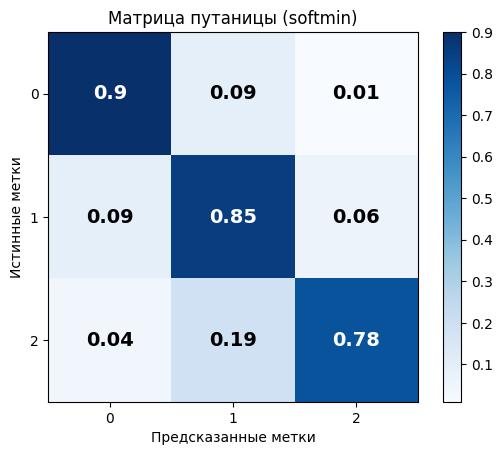

In [410]:
import matplotlib.pyplot as plt
conf_m = get_conf_matrix(predicted, y_test)
def show_conf_m(conf_m, name):
    normalized = conf_m.astype('float') / conf_m.sum(axis=1)[:, np.newaxis]
    normalized = np.round(normalized, 2)
    plt.imshow(normalized, cmap='Blues')
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            plt.text(j, i, str(normalized[i, j]),
                    ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='white' if normalized[i, j] > normalized.max()/2 else 'black')
    plt.colorbar()
    plt.xticks(np.arange(len(range(len(conf_m)))), range(len(conf_m)))
    plt.yticks(np.arange(len(range(len(conf_m)))), range(len(conf_m)))
    plt.title(f'Матрица путаницы ({name})')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()
show_conf_m(conf_m, 'softmin')

In [411]:
from sklearn.metrics import classification_report, confusion_matrix
my_precision = precision(conf_m)
my_recall = recall(conf_m)
my_accuracy = accuracy(conf_m)
my_f1 = f1(conf_m)
print(f'accuracy: {my_accuracy}\nprecision: {my_precision} {np.mean(my_precision)}\nrecall: {my_recall} {np.mean(my_recall)}\n f1 macro: {my_f1} {np.mean(my_f1)}')
print(classification_report(y_test, predicted))

accuracy: 0.8416666666666667
precision: [0.87804878 0.75555556 0.91176471] 0.848456347308571
recall: [0.9   0.85  0.775] 0.8416666666666667
 f1 macro: [0.88888889 0.8        0.83783784] 0.8422422422422423
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        80
           1       0.76      0.85      0.80        80
           2       0.91      0.78      0.84        80

    accuracy                           0.84       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.85      0.84      0.84       240



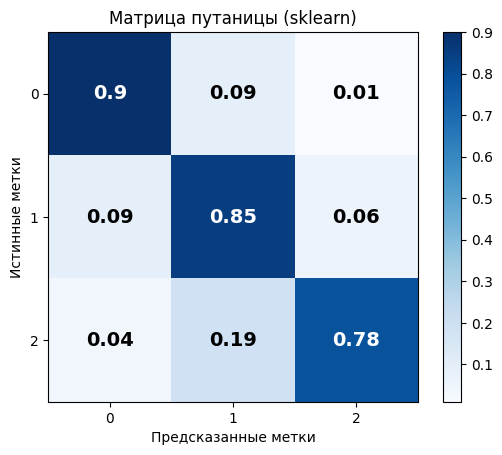

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        80
           1       0.76      0.85      0.80        80
           2       0.91      0.78      0.84        80

    accuracy                           0.84       240
   macro avg       0.85      0.84      0.84       240
weighted avg       0.85      0.84      0.84       240



In [412]:
from sklearn.neighbors import KNeighborsClassifier
sk_model = KNeighborsClassifier(metric='l2', weights='distance')
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_conf_m = confusion_matrix(y_test, sk_pred)
show_conf_m(sk_conf_m, 'sklearn')
print(classification_report(y_test, sk_pred))

In [413]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import manhattan_distances

def find_params(model, X_train, y_train,name, k_max=25, weights='distance'):
    dist_metrics = ["l1", "l2"]
    k_values = range(1, k_max)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = {metric: [] for metric in dist_metrics}

    for metric in dist_metrics:
        for k in k_values:
            f1_scores = []
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                clf = model(n_neighbors=k, metric=metric, weights=weights)
                clf.fit(X_tr, y_tr)
                y_pred = clf.predict(X_val)
                f1_scores.append(f1_score(y_val, y_pred, average='macro'))
            results[metric].append(np.mean(f1_scores))

    plt.figure(figsize=(8, 5))
    for metric in results.keys():
        plt.plot(k_values, results[metric], label=f'Metric: {metric}')
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.xticks(np.arange(min(k_values), max(k_values) + 1, 1))
    plt.title(f'Зависимость F1-score от k для разных метрик ({name})')
    plt.legend()
    plt.grid(True)
    plt.show()


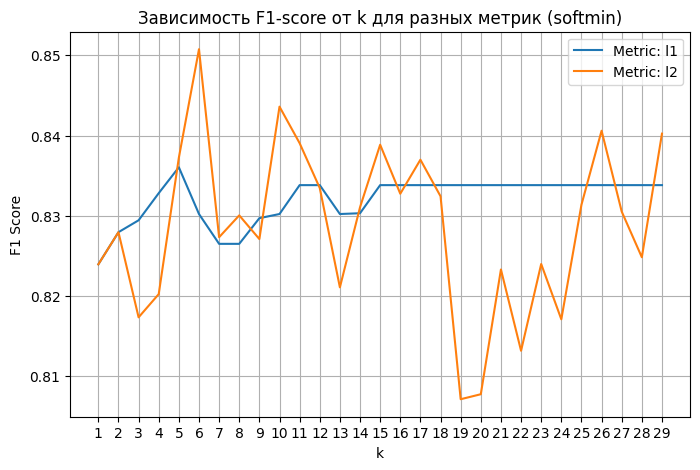

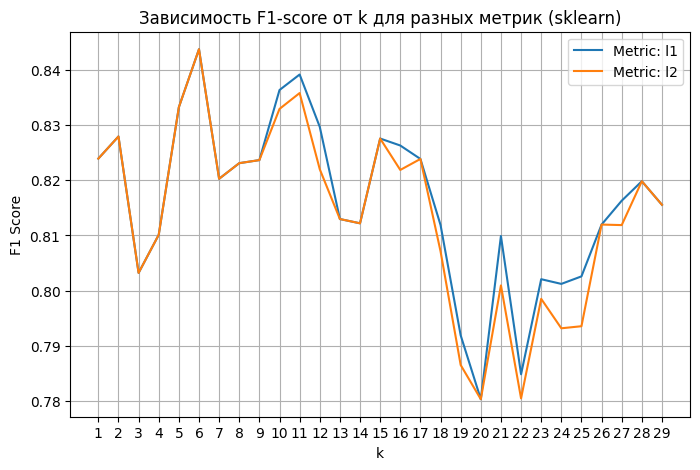

In [414]:
find_params(WeightedKNN, X_train, y_train,'softmin', k_max=30)
find_params(KNeighborsClassifier, X_train, y_train,'sklearn', k_max=30)

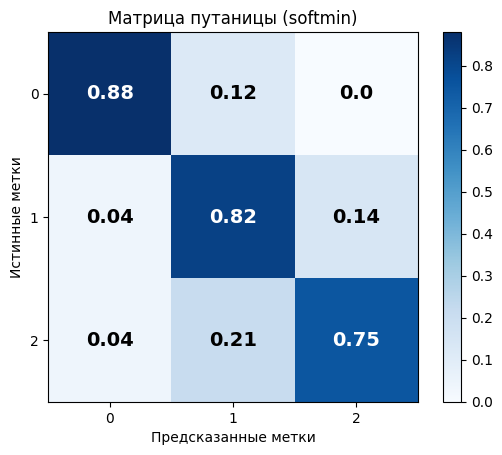

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        80
           1       0.71      0.82      0.76        80
           2       0.85      0.75      0.79        80

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240



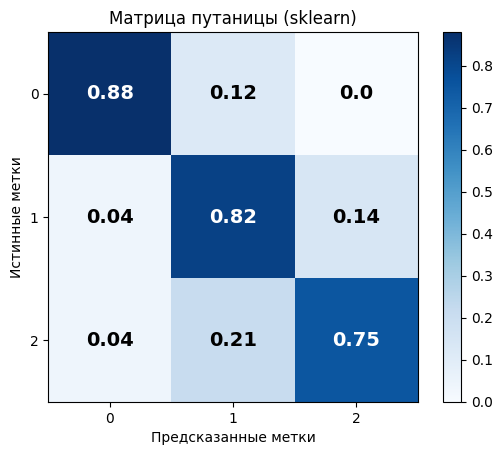

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        80
           1       0.71      0.82      0.76        80
           2       0.85      0.75      0.79        80

    accuracy                           0.82       240
   macro avg       0.83      0.82      0.82       240
weighted avg       0.83      0.82      0.82       240



In [415]:
model = WeightedKNN(n_neighbors=6)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
conf_m = confusion_matrix(y_test, predicted)
show_conf_m(conf_m, 'softmin')
print(classification_report(y_test, predicted))
sk_model = KNeighborsClassifier(n_neighbors=6, metric='l2', weights='distance')
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_conf_m = confusion_matrix(y_test, sk_pred)
show_conf_m(sk_conf_m, 'sklearn')
print(classification_report(y_test, sk_pred))

In [416]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
def load_data2(file_name, max_labels=100):
    data = []
    labels_counter = {}
    with open(file_name, 'r', encoding="utf-8") as file:
        first = True
        for row in csv.reader(file):
            if not first:
                label = int(row[0])-1
                if label in [0,1,2]:
                    data.append(((row[1]+' '+row[2]), label))
            else:
                first = not first
    random.shuffle(data)
    X = []
    y = []
    for row in data:
        label = row[1]
        if label not in labels_counter.keys():
            labels_counter[label] = 0
        if labels_counter[label] < max_labels:
            labels_counter[label]+=1
            X.append(row[0])
            y.append(row[1])
    X = model.encode(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_data2(r".\train.csv")
X_test, y_test = load_data2(r".\test.csv", 80)

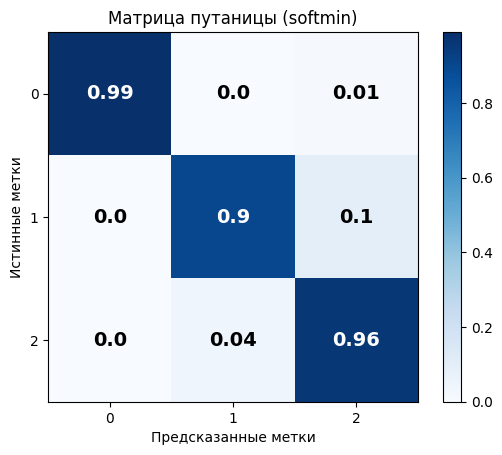

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       0.96      0.90      0.93        80
           2       0.90      0.96      0.93        80

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



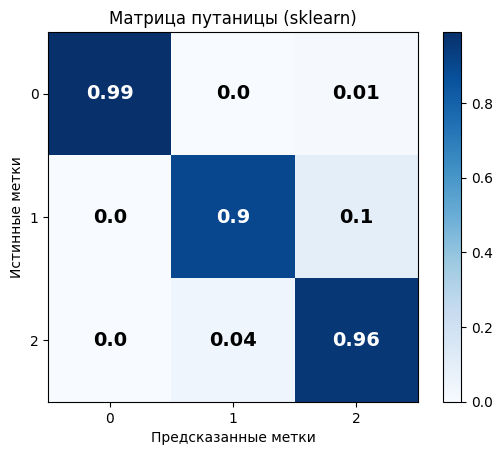

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       0.96      0.90      0.93        80
           2       0.90      0.96      0.93        80

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



In [417]:
model = WeightedKNN(n_neighbors=5)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
conf_m = confusion_matrix(y_test, predicted)
show_conf_m(conf_m, 'softmin')
print(classification_report(y_test, predicted))
sk_model = KNeighborsClassifier(n_neighbors=5, metric='l2', weights='distance')
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_conf_m = confusion_matrix(y_test, sk_pred)
show_conf_m(sk_conf_m, 'sklearn')
print(classification_report(y_test, sk_pred))

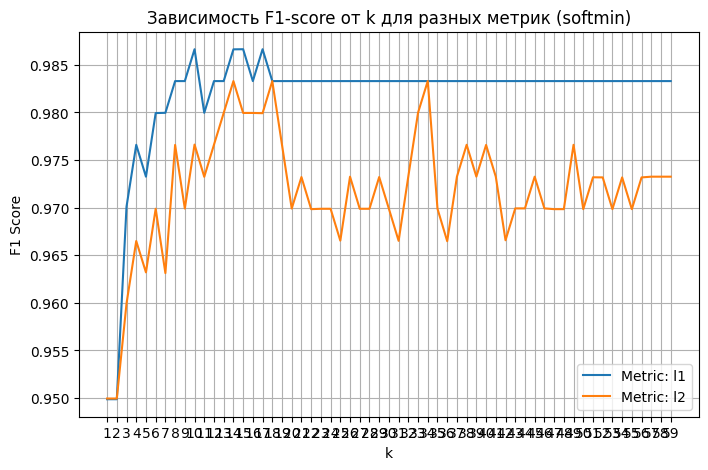

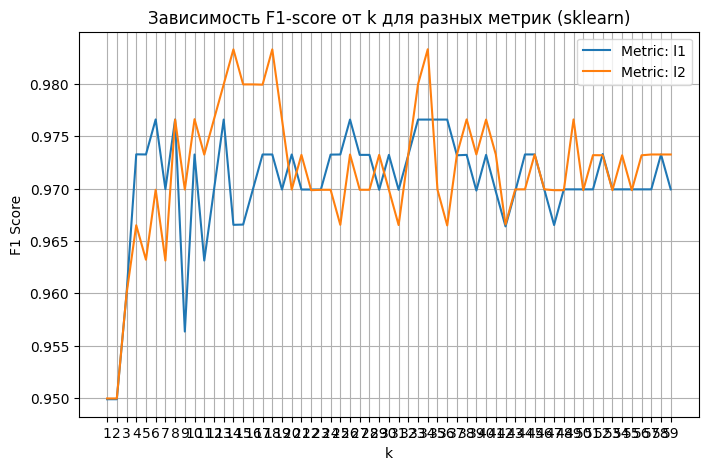

In [420]:
find_params(WeightedKNN, X_train, y_train,'softmin', k_max=60)
find_params(KNeighborsClassifier, X_train, y_train,'sklearn', k_max=60)

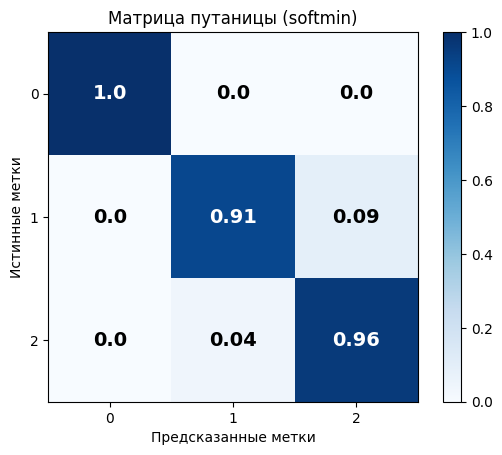

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       0.96      0.91      0.94        80
           2       0.92      0.96      0.94        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



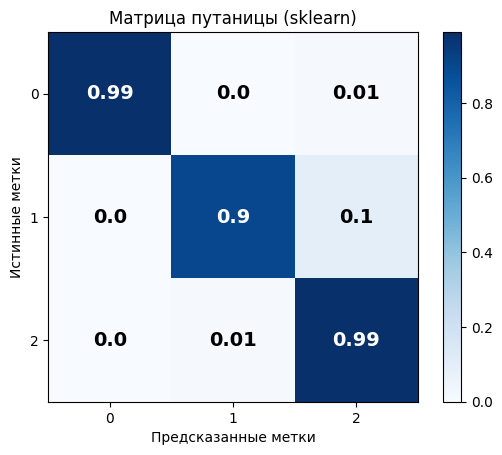

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       0.99      0.90      0.94        80
           2       0.90      0.99      0.94        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



In [419]:
model = WeightedKNN(n_neighbors=14, metric='l1')
model.fit(X_train, y_train)
predicted = model.predict(X_test)
conf_m = confusion_matrix(y_test, predicted)
show_conf_m(conf_m, 'softmin')
print(classification_report(y_test, predicted))
sk_model = KNeighborsClassifier(n_neighbors=14, metric='l2', weights='distance')
sk_model.fit(X_train, y_train)
sk_pred = sk_model.predict(X_test)
sk_conf_m = confusion_matrix(y_test, sk_pred)
show_conf_m(sk_conf_m, 'sklearn')
print(classification_report(y_test, sk_pred))

# Отчет

## Метрики

* Accuracy - "аккуратность модели", просто доля правильных ответов (например 0.82 означает, что почти каждое пятое предсказание ошибочно);
* Precision - "нежелание" модели приписать тот или иной объект к данному классу. Этот показатель высокий, если либо модель очень точная, либо очень не хочет приписывать этот класс спорным объектам (например 0.92 у класса 0 означает, что модель не приписывает этот класс кому попало, а значение 0.71 у класса 1 означает, что модель чаще приписывает этот класс кому попало);
* Recall - "нежелание" модели пропустить данный класс. Опять-же, либо модель очень точная, либо считает, что лучше приписать спорный объект к этому классу, чем не приписать (например 0.88 у класса 0 означает, что модель скорее припишет объект к этому классу даже в спорных ситуациях, а значение 0.75 у класса 2 означает, что модель чаще определяет объекты этого класса другим классам);
* F1 - гармоническое среднее двух последних (например 0.90 у класса 0 означает, что модель осторожна с этим классом в обоих смыслах, а значение 0.76 у класса 1 означает, что модель не осторожна с этим классом в обоих смыслах);
* macro avg F1 - усредненное F1 (насколько модель в среднем хорошо угадывает класс объекта).


## Анализ разных k

* при k~=1 у модели очень высокая емкость (если опустить тот факт, что тут нет обучения то) модель "запомнила" все тренировочные данные, может идеально разделить классы, если они плотные, но не готова к тому, что в реальности возможны спорные моменты;
* при k~=inf емкость модели сильно снижается. Из-за малого масштаба она уже не замечет многообразия признаком и просто грубо усредняет;
* в идеале должен быть баланс: нужно сравнивать как минимум несколько соседних многообразий, но при этом не делать слишком мелкий масштаб, чтобы не потерять их вообще.

## Метрики

Для one hot лучше l2, так как пространство очень разраженное, вектора огромные, а l1 в больших разряженных размерностей хуже отражает мелкие отличия признаков. Иными словами, l2 в данном случает адекватнее и плавнее отражает различия и сходства векторов. Это не говоря уже про особенность при работе с экспонентой, о которой далее.

## Различия реализации

По метрикам видно, что реализации не отличаются вообще. Однако отличия есть. В классическом wKNN для весов используется формула 1/(d+eps), в моей реализации я заменил ее на стабилизированный softmin(d). Принцип работы тот-же, только нет необходимости думать об переполнении или делении на ноль. Но exp также гораздо сильнее чем 1/d ужимает пространство, то есть все большие расстояния коллапсируют в 0. Это в комбинации с l1 нормой (которая сильно раздувает расстояния) приводит к тому, что модель перестает зависеть от больших k (сколько не добавляй новых соседей их веса все равно будут примерно ноль).

## Curse of dimensionality

Да, действительно, если например для этого набора данных взять полную выборку, то numpy выбьет по памяти, тогда как например у предобученных энкодеров энбединги фиксированны и спокойно помещаются в память даже при большой выборке.

## Кросс валидация

В целом, все не сверх стабильно, можно утверждать, что после k = 10-15 пики становятся ниже. Но плавного убывания при больших k не наблюдается.

## (бонус) Энкодер

В уменьшении размерности я пошел по радикальному пути, применив на эту выборку MiniLM. Как видно, KNN стал работать заметно шустрее, да и точность тоже сильно увеличилась


